# Graph Neural Network
---
> Design and ideas about GNNs for vertex dynamics sim-n

👷🚧 **To-Do**<br>
- *Training loop*:
    - [ ] Training loop w/ validation set error monitoring, and best model saving
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock` (a more general block/model that can be composed into a deep residual network). "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form).
    - [ ] Convert "long" AS movies into graph datasets.
- [ ] *Prediction stage*: read \{test, val, train\} data and predict w/ saving.
- [ ] Ablation dataset (*real*).
- [ ] Larger simul-n dataset.

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

**Examples**:
- General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5,5) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [5]:
from simgnn.datasets import VertexDynamics, CellData
from simgnn.nn import mlp, Message, AggregateUpdate, Aggregate
from simgnn.transforms import Pos2Vec, ScaleVelocity
# from torch_geometric.utils import to_undirected as T_undir

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


In [5]:
# test = VertexDynamics('../../../dataDIR/simgnn_data/test/')

In [7]:
# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=20*0.857) ,
                           ScaleVelocity(0.857)])
# training dataset
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/', transform=Tnorm)

In [12]:
print('',vtxdata,'\n',vtxdata[0])

 VertexDynamics(95) 
 CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])


In [7]:
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [8]:
data.is_undirected()

False

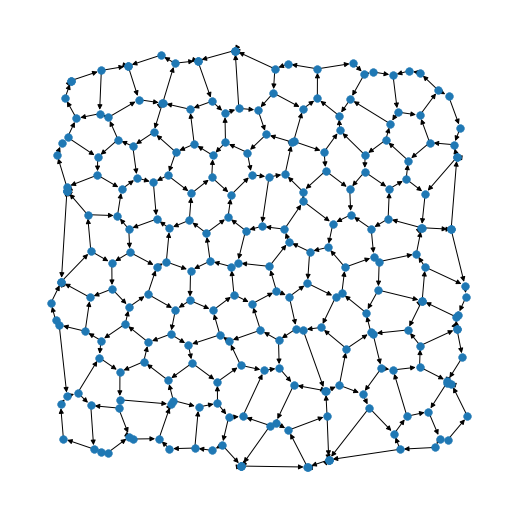

In [9]:
nx.draw(to_networkx(data),pos=dict(enumerate(data.pos.numpy())), node_size=60)

In [44]:
# in order to track the batch id for var-s add its key to "follow_batch":
loader = DataLoader(vtxdata, batch_size=2,follow_batch=['cell_pressures','edge_index'])
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids
batch = next(iter(loader))
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==0).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==0])),
#     pos=dict(enumerate(batch.pos[batch.batch==0].numpy())),
#     node_size=60, node_color='r',edge_color='r')
# nx.draw( to_networkx(
#     CellData(num_nodes = torch.sum(batch.batch==1).item(),
#              edge_index = batch.edge_index[:,batch.edge_index_batch==1]-240)),
#     pos=dict(enumerate(batch.pos[batch.batch==1].numpy() +1.5)),
#     node_size=60)
batch

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], cell_pressures_batch=[200], edge_attr=[678, 2], edge_index=[2, 678], edge_index_batch=[678], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])